<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#calculate-size-of-network-overlap,-and-compare-to-expected-size" data-toc-modified-id="calculate-size-of-network-overlap,-and-compare-to-expected-size-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>calculate size of network overlap, and compare to expected size</a></span></li><li><span><a href="#Output-network-overlap-to-NDEx/cytoscape-for-clustering/annotation" data-toc-modified-id="Output-network-overlap-to-NDEx/cytoscape-for-clustering/annotation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Output network overlap to NDEx/cytoscape for clustering/annotation</a></span></li><li><span><a href="#Annotate-network-and-upload-to-NDEx" data-toc-modified-id="Annotate-network-and-upload-to-NDEx-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Annotate network and upload to NDEx</a></span></li></ul></div>

# NetColoc analysis of rare and common variants in Externalizing and High Responders

Example of NetColoc workflow on genes associated with rare and common variants in autism.

**Some background:**

Here we introduce NetColoc, a tool which evaluates the extent to which two gene sets are related in network space, i.e. the extent to which they are colocalized in a molecular interaction network, and interrogates the underlying biological pathways and processes using multiscale community detection. This framework may be applied to any number of scenarios in which gene sets have been associated with a phenotype or condition, including rare and common variants within the same disease, genes associated with two comorbid diseases, genetically correlated GWAS phenotypes, GWAS across two different species, or gene expression changes after treatment with two different drugs, to name a few. NetColoc relies on a dual network propagation approach to identify the region of network space which is significantly proximal to both input gene sets, and as such is highly effective for small to medium input gene sets


In [1]:
# load required packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

from IPython.display import display

import getpass
import ndex2

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys

# % matplotlib inline

In [2]:
import sys
sys.path.append('../netcoloc/')

import netprop_zscore
import netprop
import network_colocalization

import imp
imp.reload(netprop_zscore)
imp.reload(netprop)
imp.reload(network_colocalization)

<module 'network_colocalization' from '../netcoloc/network_colocalization.py'>

In [3]:
nx.__version__

'2.1'

In [4]:
# set random seed to enable reproducibility between runs
import random
np.random.seed(1)

# 1. Load two gene sets of interest


Identify two gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. For example, genes associated with significant loci from GWAS (common variants). Summary statistics are readily available for most GWAS. We note there are existing methods to map summary statistics to corresponding genes (REFS MAGMA, TWAS/PREDIXCAN/ FUMA/ PASCAL, etc). In our work we use the PASCAL algorithm (https://urldefense.proofpoint.com/v2/url?u=https-3A__journals.plos.org_ploscompbiol_article-3Fid-3D10.1371_journal.pcbi.1004714&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=y71I4_EMTPQGKL39szCrHmsERSpP-U_zu2kEpZFs3N8&m=ZYr6IOEWMIcomIhfq_MBTGMgNj1WFJnV97BQmLR5OCo&s=Qq_6IFlB-fag85XYMkSTHhaqVUeL2M83riO02wqYD0Q&e= ), a positional mapper which accounts for linkage disequilibrium. Another example is genes associated with damaging variants from case-control studies in exome sequencing (rare variants). There exist well established pipelines for identifying deleterious variants in exome sequencing (REFS). In this case the variant-gene mapping is trivial because all variants are by definition found within the gene body. In practice, less than 500 genes work best as input to NetColoc, because of sampling issues.

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [5]:
# load rare variants (from https://urldefense.proofpoint.com/v2/url?u=https-3A__www.sciencedirect.com_science_article_abs_pii_S0092867419313984-29-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=y71I4_EMTPQGKL39szCrHmsERSpP-U_zu2kEpZFs3N8&m=ZYr6IOEWMIcomIhfq_MBTGMgNj1WFJnV97BQmLR5OCo&s=tbi18sa5KHwmvhHHnNRg2CA7hxJ4iWaZA19FOobzEOQ&e= #change path
#ASD_rare_df = pd.read_csv('../docs/data/HC_genes/Satterstrom--Top-102-ASD-genes--May2019.csv')
ext_hm_df = pd.read_csv('/Users/brittanyleger/Documents/BMS/year1/BMS_spring_2021/palmer_rotation/network_externalizing/hm_gene_lists/Hm_ext_bfYes_pLess_1e-8.csv')
#change all ASD_rare to EXT_hm
#ASD_rare_df.index=ASD_rare_df['gene']
ext_hm_df.index=ext_hm_df['Gene']
print('number of human genes:')
#print(len(ASD_rare_df))
print(len(ext_hm_df))
ext_hm = ext_hm_df.index.tolist() # define rare variant genes to seed network propagation
print(ext_hm_df[0:5])

number of human genes:
1071
                      Gene  hm
Gene                          
ENPP7P1            ENPP7P1   1
MIR4765            MIR4765   1
LINC01347        LINC01347   1
ERI1                  ERI1   1
RP11-107E5.3  RP11-107E5.3   1


In [6]:
# load common variant genes (ASD summary stats from LINK, mapped using PASCAL)
#change path
ext_rat_df = pd.read_csv('/Users/brittanyleger/Documents/BMS/year1/BMS_spring_2021/palmer_rotation/network_externalizing/rat_gene_lists/Rat_Hm_ortholog_sheet4.csv')
#change all ASD_common to EXT_ms
#pthresh=1E-4 # set p-value cutoff for common variant genes
#ASD_common_genes = ASD_common_df[ASD_common_df['pvalue']<pthresh]['gene_symbol'].tolist()
ext_rat_df.index=ext_rat_df['Gene']
ext_rat = ext_rat_df.index.tolist()
print('number of rat orthologs:')
print(len(ext_rat))
print(ext_rat[0:5])


number of rat orthologs:
257
['LARP6', 'PRSS35', 'TMEM144', 'CLIC2', 'AK1']


In [7]:
# how much overlap between gene sets?
print('number of human genes and rat orthologs overlapping:')
print(len(np.intersect1d(ext_hm,ext_rat)))

number of human genes and rat orthologs overlapping:
9


# 2. Load interactome

**Coverage**. Larger, denser interactomes will be more inclusive and be amenable to creating more granular models. Human curated interactomes are smaller, sparser and are biased towards known biology. Many, however, have richer descriptions of the relationships. Data derived interactomes based on specific projects have the advantage that the experimental context is well-defined and consistent.  


**Interaction Types**. The edges that were useful in computing the coloc may not be useful for interpretation. For example, the edges in PCNet are not typed. For purposes of interpretation we need to know how the genes relate to each other. Further, we are best able to understand physical interactions, and so it may be most useful to review the nodes in a community or other subnetwork using a protein-protein interactome, or at least one in which the edges can be filtered when needed.

**Net recommendation**: use an inclusive interactome for generating the model but then annotate subsystem networks with relationships derived from richer, if less comprehensive, sources. Or from sources specifically relevant to the experimental context.


**Usage note**: PCnet is a general purpose interactome, a good starting place https://urldefense.proofpoint.com/v2/url?u=https-3A__www.sciencedirect.com_science_article_pii_S2405471218300954&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=y71I4_EMTPQGKL39szCrHmsERSpP-U_zu2kEpZFs3N8&m=ZYr6IOEWMIcomIhfq_MBTGMgNj1WFJnV97BQmLR5OCo&s=lNlG7inXe2ZMLE4_0OFAPDv_uYgy3odapFvwcvtzSdo&e= 

In [8]:

interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
ndex_server='public.ndexbio.org'
ndex_user= None
ndex_password= None
G_PC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_PC.nodes)

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_PC.nodes))
print('\nnumber of edges:')
print(len(G_PC.edges))

number of nodes:
18820

number of edges:
2693250


In [9]:
pc_nodes = list(G_PC.nodes)

# 3. Network co-localization

Network propagation from genes on selected interactome
- Control for degree of input genes
- Generate a proximity z-score, which defines genes which are closer to input set than expected by chance.
- Repeat for rare and common variant genes, defined above

Background on network propagation: https://urldefense.proofpoint.com/v2/url?u=https-3A__www.nature.com_articles_nrg.2017.38.pdf-3Forigin-3Dppub-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=y71I4_EMTPQGKL39szCrHmsERSpP-U_zu2kEpZFs3N8&m=ZYr6IOEWMIcomIhfq_MBTGMgNj1WFJnV97BQmLR5OCo&s=t6oPwOIbxOOdXhdnplaA1GeJOVcfa1PHh_ak0SMGXeU&e= 

In [10]:
# pre calculate mats used for netprop... this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_PC, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


In [11]:
# subset seed genes to those found in interactome
print(len(ext_rat))
ext_rat = list(np.intersect1d(ext_rat,pc_nodes))
print(len(ext_rat))

print(len(ext_hm))
ext_hm = list(np.intersect1d(ext_hm,pc_nodes))
print(len(ext_hm))


257
246
1071
470


In [12]:
# Rare variant netprop
print('\nCalculating human gene z-scores: ')
z_hm, Fnew_hm, Fnew_rand_hm = netprop_zscore.calculate_heat_zscores(w_double_prime, pc_nodes, 
                                                                    dict(G_PC.degree), 
                                                                    ext_hm, num_reps=1000,
                                                                    minimum_bin_size=100)

z_hm = pd.DataFrame({'z':z_hm})

z_hm.sort_values('z',ascending=False).head()


Calculating human gene z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
C17orf58,40.709145
PPIH,29.865893
AK2,28.527911
RPS26,26.460710
ASCC3,26.176368


In [13]:
# common variant netprop
print('\nCalculating common variant z-scores: ')
z_rat, Fnew_rat, Fnew_rand_rat = netprop_zscore.calculate_heat_zscores(w_double_prime, pc_nodes, 
                                                                    dict(G_PC.degree), 
                                                                    ext_rat, num_reps=1000,
                                                                    minimum_bin_size=100)

z_rat = pd.DataFrame({'z':z_rat})
z_rat.sort_values('z',ascending=False).head()


Calculating common variant z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
MDH1,26.258189
PSME4,23.364898
DUT,21.990922
LANCL1,21.666728
TUFM,21.660020


## calculate size of network overlap, and compare to expected size


Size of network co-localization subgraph compared to null model created by permuting individual propagation z-scores. 


Note: seed genes are excluded from this calculation



In [14]:
from scipy.stats import hypergeom
from scipy.stats import norm

# ------ customize this section based on your gene sets and how they should be labeled -------
z_dict = {'ext_hm':z_hm,'ext_rat':z_rat}

seed_dict = {'ext_hm':ext_hm,'ext_rat':ext_rat}
# --------------------------------------------------------------------------------------------

# save the num overlap and overlap p-val in dataframes

focal_diseases = ['ext_hm','ext_rat']

network_num_overlap = pd.DataFrame(np.zeros((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_num_overlap.columns = focal_diseases

network_obs_exp = pd.DataFrame(np.zeros((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_obs_exp.columns = focal_diseases

network_pval_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_pval_overlap.columns = focal_diseases

network_exp_mean_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_exp_mean_overlap.columns = focal_diseases

network_exp_std_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_exp_std_overlap.columns = focal_diseases


zthresh=3
for i in np.arange(len(focal_diseases)-1):
    for j in np.arange(1+i,len(focal_diseases)):
        d1=focal_diseases[i]
        d2=focal_diseases[j]
        
        seed1 = seed_dict[d1]
        seed2 = seed_dict[d2]
        
        z1=z_dict[d1]
        z1_noseeds = z1.drop(list(np.intersect1d(seed1+seed2,z1.index.tolist())))
        z2=z_dict[d2]
        z2_noseeds = z2.drop(list(np.intersect1d(seed1+seed2,z2.index.tolist())))

        # replace hypergeometric with permutation empirical p
#         z_d1d2_size,high_z_rand=network_colocalization.calculate_expected_overlap(d1,d2,z1_noseeds,z2_noseeds,
#                                                            plot=False,numreps=1000,zthresh=zthresh)

        z_d1d2_size,high_z_rand=network_colocalization.calculate_expected_overlap(z1['z'],z2['z'],d1,d2,
                                                           plot=False,num_reps=1000,z_score_threshold=zthresh)
        ztemp = (z_d1d2_size-np.mean(high_z_rand))/np.std(high_z_rand)
        ptemp = norm.sf(ztemp)
        print(d1+' + '+d2)
        print('size of network intersection = '+str(z_d1d2_size))
        obs_exp_temp = float(z_d1d2_size)/np.mean(high_z_rand)
        print('observed size/ expected size = ' + str(obs_exp_temp))
        print('p = '+ str(ptemp))
        
        
        network_num_overlap.loc[d1][d2]=z_d1d2_size
        network_num_overlap.loc[d2][d1]=z_d1d2_size

        network_pval_overlap.loc[d1][d2]=ptemp
        network_pval_overlap.loc[d2][d1]=ptemp
        
        network_obs_exp.loc[d1][d2]=obs_exp_temp
        network_obs_exp.loc[d2][d1]=obs_exp_temp
        
        network_exp_mean_overlap.loc[d1][d2]=np.mean(high_z_rand)
        network_exp_mean_overlap.loc[d2][d1]=np.mean(high_z_rand)
        
        network_exp_std_overlap.loc[d1][d2]=np.std(high_z_rand)
        network_exp_std_overlap.loc[d2][d1]=np.std(high_z_rand)
        
        

ext_hm + ext_rat
size of network intersection = 180
observed size/ expected size = 0.7880186147508329
p = 0.9999057469849905


(-0.5, 0.5)

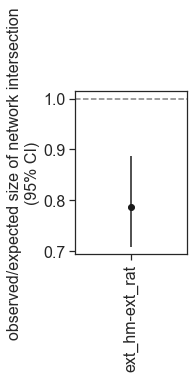

In [15]:
# plot the overlap ... useful when there are lots of comparisons... not so much here
xlabels = []
observed_overlap_list=[]
mean_exp_overlap_list=[]
std_exp_overlap_list=[]
for i in range(len(focal_diseases)-1): #[0]: #
    for j in range(i+1,len(focal_diseases)):
        di = focal_diseases[i]
        dj=focal_diseases[j]
        xlabels.append(di+'-'+dj)
        observed_overlap_list.append(network_num_overlap.loc[di][dj])
        mean_exp_overlap_list.append(network_exp_mean_overlap.loc[di][dj])
        std_exp_overlap_list.append(network_exp_std_overlap.loc[di][dj])
        
obs_div_exp_list = np.divide(observed_overlap_list,mean_exp_overlap_list)
# change to 95% confidence interval (*1.96 sigma)
yerr_lower =  np.subtract(obs_div_exp_list,np.divide(observed_overlap_list,np.add(mean_exp_overlap_list,1.96*np.array(std_exp_overlap_list))))
yerr_upper = np.subtract(np.divide(observed_overlap_list,np.subtract(mean_exp_overlap_list,1.96*np.array(std_exp_overlap_list))),obs_div_exp_list)

log_yerr_lower = np.subtract(np.log2(obs_div_exp_list),np.log2(np.divide(observed_overlap_list,np.add(mean_exp_overlap_list,2*np.array(std_exp_overlap_list)))))
log_yerr_upper = np.subtract(np.log2(np.divide(observed_overlap_list,np.subtract(mean_exp_overlap_list,2*np.array(std_exp_overlap_list)))),np.log2(obs_div_exp_list))

log_obs_div_exp=np.log2(obs_div_exp_list)
# log_yerr_lower=np.log2(obs_div_exp_lower_list)
# log_yerr_upper=np.log2(obs_div_exp_upper_list)

network_intersection_df = pd.DataFrame({'name':xlabels,'observed_overlap':observed_overlap_list,
                                       'log2_obs_div_exp':log_obs_div_exp,
                                       'log2_yerr_lower':log_yerr_lower,
                                       'log2_yerr_upper':log_yerr_upper,
                                        'obs_div_exp':obs_div_exp_list,
                                       'yerr_lower':yerr_lower,
                                       'yerr_upper':yerr_upper})
network_intersection_df.index=network_intersection_df['name']

# sort it 
network_intersection_df=network_intersection_df.sort_values('obs_div_exp',ascending=False)

plt.figure(figsize=(2,3))
plt.errorbar(np.arange(len(network_intersection_df)),network_intersection_df['obs_div_exp'],
             yerr=[network_intersection_df['yerr_lower'],network_intersection_df['yerr_upper']],
             fmt='o',color='k')
tmp=plt.xticks(np.arange(len(observed_overlap_list)),network_intersection_df.index.tolist(),fontsize=16,rotation='vertical')
plt.ylabel('observed/expected size of network intersection\n(95% CI)',fontsize=16)
#plt.plot([0,len(obs_div_exp_list)],[0,0],'gray','--')
plt.hlines(1,xmin=-.5,xmax=len(network_intersection_df),color='gray',linestyles='dashed')
# plt.ylim([0.8,1.5])
plt.yticks(fontsize=16)
plt.xlim([-.5,len(network_intersection_df)-.5])

## Output network overlap to NDEx/cytoscape for clustering/annotation

----- If a significant overlap is detected: ------

Create the network co-localization subgraph, save network to NDEX, then open in Cytoscape for clustering/annotation. (See CDAPS documentation) 


In [16]:
network_colocalization.calculate_network_overlap?

In [17]:
# select genes in network intersection, make a subgraph
d1='ext_hm'
d2='ext_rat'
z1=z_dict[d1]
z2=z_dict[d2]

G_overlap = network_colocalization.calculate_network_overlap_subgraph(G_PC,z1['z'],z2['z'],z_score_threshold=3)
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))

180
418


In [18]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df[d1+'_seeds']= 0
node_df[d2+'_seeds']= 0
node_df[d1+'_seeds'].loc[list(np.intersect1d(seed_dict[d1],node_df.index.tolist()))]=1
node_df[d2+'_seeds'].loc[list(np.intersect1d(seed_dict[d2],node_df.index.tolist()))]=1
node_df['z_'+d1]=z1.loc[list(G_overlap.nodes)]['z']
node_df['z_'+d2]=z2.loc[list(G_overlap.nodes)]['z']
node_df['z_both']=node_df['z_'+d1]*node_df['z_'+d2]

node_df = node_df.sort_values('z_both',ascending=False)
node_df.head()

,ext_hm_seeds,ext_rat_seeds,z_ext_hm,z_ext_rat,z_both
PHF20L1,1,1,16.082303,13.350175,214.701554
GABBR1,1,1,14.283185,14.895739,212.758588
NQO1,1,1,14.315178,13.699111,196.105205
ZNF23,1,1,14.439124,12.226255,176.536411
RIPK2,1,1,11.591712,10.445644,121.082890


## Annotate network and upload to NDEx


In [19]:
# ----- a number of properties should be customized here ------

#Annotate network
print(len(G_overlap.nodes()))
print(len(G_overlap.edges()))
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name('ext_hm_rat_network_temp_set14') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'ext_hm_seeds' or row == 'ext_rat_seeds':
            data_type = 'boolean'
            if value == 0:
                value = False
            else:
                value = True
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

#Upload to NDEx
#SERVER = input('NDEx server (probably ndexbio.org): ')
SERVER ='ndexbio.org'
USERNAME = 'bsleger'
PASSWORD = 'Pyjgor-3sarwe-puvfyb'
#USERNAME = input('NDEx user name: ')
#PASSWORD = getpass.getpass('NDEx password: ')
network_uuid = G_overlap_cx.upload_to(SERVER, USERNAME, PASSWORD)



180
418
Generating CX


# 4. Build multiscale systems map

This step performed in Cytoscape

https://urldefense.proofpoint.com/v2/url?u=https-3A__apps.cytoscape.org_apps_cycommunitydetection-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=y71I4_EMTPQGKL39szCrHmsERSpP-U_zu2kEpZFs3N8&m=ZYr6IOEWMIcomIhfq_MBTGMgNj1WFJnV97BQmLR5OCo&s=wF0VG9aCfqTpHObc1SiqaQ-maUxEMjlvpwkG-23NetU&e= 
Instructions for use available in the manuscript